# **GNN for CORA: An Example Graph Neural Network Application**


The example code is based on code from: https://github.com/praxidike97/GraphNeuralNet/tree/master

Article: https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

The Cora dataset: https://graphsandnetworks.com/the-cora-dataset/

Community detection in Cora: https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/6_line_graph.html

Planetoid: https://github.com/kimiyoung/planetoid

In [1]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

1.8.0+cu101
Device:  cuda


In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 11.0MB/s 
     |████████████████████████████████| 1.5MB 12.0MB/s 
     |████████████████████████████████| 194kB 13.5MB/s 
     |████████████████████████████████| 235kB 28.0MB/s 
     |████████████████████████████████| 2.2MB 27.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


In [3]:
import os
import networkx as nx
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Colab Notebooks/CORA/' 
#data_dir = os.path.expanduser("~/data/cora")

Mounted at /content/gdrive


In [4]:
edgelist = pd.read_csv(root_path + "cora.cites", sep='\t', header=None, names=["target", "source"])
# 5429 pairs of numbers

In [5]:
edgelist

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [6]:
edgelist.shape

(5429, 2)

In [7]:
edgelist.sample(frac=0.25).head(5)

,target,source
143,35,646809
2876,35778,1125469
4689,252715,601561
2831,34257,34263
4935,521252,1125992


In [8]:
edgelist.sample(frac=0.1)

,target,source
1195,6184,1120731
4002,108963,1095507
2776,32276,636511
3516,66794,1105505
2926,36140,46500
...,...,...
2701,31055,1106630
2227,19621,83826
5139,628751,950986
1466,6923,6941


In [9]:
edgelist.head(1000)

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
995,4330,69418
996,4330,753265
997,4330,949217
998,4335,1104300


In [10]:
edgelist["label"] = "cites"
edgelist.shape

(5429, 3)

In [11]:
edgelist.head(1000)

,target,source,label
0,35,1033,cites
1,35,103482,cites
2,35,103515,cites
3,35,1050679,cites
4,35,1103960,cites
...,...,...,...
995,4330,69418,cites
996,4330,753265,cites
997,4330,949217,cites
998,4335,1104300,cites


In [12]:
edgelist.sample(frac=1).head(5)

,target,source,label
1211,6209,181782,cites
1848,12347,16451,cites
63,35,190697,cites
289,910,1116569,cites
3937,101263,1139928,cites


In [13]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [14]:
Gnx.nodes[1103985]

{'label': 'paper'}

In [15]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(root_path + "cora.content", sep='\t', header=None, names=column_names)
# 2708 lines of numbers, with a text label at the end of each line.
# a number (which is the index of a paper) + 1433 0 or 1 + subject
# The dictionary consists of 1433 unique words.
# The Cora dataset consists of 2708 scientific publications classified into one of seven classes.

In [16]:
node_data.shape

(2708, 1434)

In [17]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [18]:
node_data.head(5)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_1394,w_1395,w_1396,w_1397,w_1398,w_1399,w_1400,w_1401,w_1402,w_1403,w_1404,w_1405,w_1406,w_1407,w_1408,w_1409,w_1410,w_1411,w_1412,w_1413,w_1414,w_1415,w_1416,w_1417,w_1418,w_1419,w_1420,w_1421,w_1422,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [19]:
# https://github.com/praxidike97/GraphNeuralNet/tree/master
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()


def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))


def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # The negative log likelihood loss function.
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

Processing...
Done!


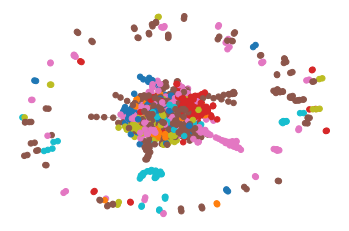

In [20]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

plot_dataset(dataset)

In [21]:
print(dataset)
print("name: ", dataset.name)
print("num_classes: ", dataset.num_classes)
print("num_edge_features: ", dataset.num_edge_features)
print("num_node_features: ", dataset.num_node_features)
print(dataset[0])
print("Number of Edges: ", dataset[0].edge_index.shape[1] / 2)

Cora()
name:  Cora
num_classes:  7
num_edge_features:  0
num_node_features:  1433
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of Edges:  5278.0


In [22]:
torch.set_printoptions(edgeitems=11)
print(dataset[0].edge_index)

tensor([[   0,    0,    0,    1,    1,    1,    2,    2,    2,    2,    2,  ...,
         2703, 2704, 2705, 2706, 2706, 2706, 2706, 2707, 2707, 2707, 2707],
        [ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666, 1986,  ...,
         1298,  641,  287,  165,  169, 1473, 2707,  165,  598, 1473, 2706]])


In [23]:
dataset[0].edge_index.shape

torch.Size([2, 10556])

In [24]:
print("Label: ", dataset[0].y[0])
print("Label: ", dataset[0].y[1])
print("Label: ", dataset[0].y[2])
print("Label: ", dataset[0].y[3])
for i in dataset[0].y: 
  print(int(i),end=" ")
m = {}
for i in range(len(dataset[0].y)):
  s = int(dataset[0].y[i])
  if s in m:
    m[s] += 1
  else:
    m[s] = 1
print(" ")
print(m)
s = 0
for i in m:
  s += m[i]
print("Total: ", s)

Label:  tensor(3)
Label:  tensor(4)
Label:  tensor(4)
Label:  tensor(0)
3 4 4 0 3 2 0 3 3 2 0 0 4 3 3 3 2 3 1 3 5 3 4 6 3 3 6 3 2 4 3 6 0 4 2 0 1 5 4 4 3 6 6 4 3 3 2 5 3 4 5 3 0 2 1 4 6 3 2 2 0 0 0 4 2 0 4 5 2 6 5 2 2 2 0 4 5 6 4 0 0 0 4 2 4 1 4 6 0 4 2 4 6 6 0 0 6 5 0 6 0 2 1 1 1 2 6 5 6 1 2 2 1 5 5 5 6 5 6 5 5 1 6 6 1 5 1 6 5 5 5 1 5 1 1 1 1 1 1 1 4 3 0 3 6 6 0 3 4 0 3 4 4 1 2 2 2 3 3 3 3 0 4 5 0 3 4 3 3 3 2 3 3 2 2 6 1 4 3 3 3 6 3 3 3 3 0 4 2 2 6 5 3 5 4 0 4 3 4 4 3 3 2 4 0 3 2 3 3 4 4 0 3 6 0 3 3 4 3 3 5 2 3 2 4 1 3 2 2 3 3 3 3 5 1 3 1 3 5 0 3 5 0 4 2 4 2 4 4 5 4 3 5 3 3 4 3 0 4 5 0 3 6 2 5 5 5 3 2 3 0 4 5 3 0 4 0 3 3 0 0 3 5 4 4 3 4 3 3 2 2 3 0 3 1 3 2 3 3 4 5 2 1 1 0 0 1 6 1 3 3 3 2 3 3 0 3 4 1 3 4 3 2 0 0 4 2 3 2 1 4 6 3 2 0 3 3 2 3 4 4 2 1 3 5 3 2 0 4 5 1 3 3 2 0 2 4 2 2 2 5 4 4 2 2 0 3 2 4 4 5 5 1 0 3 4 5 3 4 5 3 4 3 3 1 4 3 3 5 2 3 2 5 5 4 3 3 3 3 1 5 3 3 2 6 0 1 3 0 1 5 3 6 3 6 0 3 3 3 5 4 3 4 0 5 2 1 2 4 4 4 4 3 3 0 4 3 0 5 2 0 5 4 4 4 3 0 6 5 2 4 5 1 3 5 3 0 3 5 1 1 0 3 4 

In [33]:
sum = 0
for indexi, i in enumerate(dataset[0].x):
    c = 0
    for index, j in enumerate(i):
      if (index < 80  or index >len(i)-10 ) and indexi < 20:  
        print(int(j),end=" ")
      elif index == 80 and indexi < 20: 
        print("...",end=" ")
      c+=int(j)
    sum += c
    if indexi < 20 :
      print(" Sum:", '{:3}'.format(c), "length:", len(i))
print("......\ntotal: ", sum, "height: ", len(dataset[0].x))

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 . sum:   9 length: 1433
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 . sum:  23 length: 1433
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 . sum:  19 length: 1433
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 . sum:  21 length: 1433
0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model = Net(dataset).to(device)
print("Model: ", model)
data = dataset[0].to(device)
print("Data: ", data)
print("Data.test_mask: ", data.test_mask)
print("Data.train_mask: ", data.train_mask)
print("Data.val_mask: ", data.val_mask)

m = {}
print("Length of data.test_mask: ", len(data.test_mask))
for i in range(len(data.test_mask)):
  s = str(data.test_mask[i]) + str(data.train_mask[i]) + str(data.val_mask[i])
  if s in m:
    m[s] += 1
  else:
    m[s] = 1
for i in m:
  print(i, m[i])

c = 0
d = 0
for i in data.test_mask:
  if i == True:
    c += 1
  elif i == False:
    d += 1
print("data.test_mask : ", "True: ", c, "; False: ", d)

c = 0
d = 0
for i in data.train_mask:
  if i == True:
    c += 1
  elif i == False:
    d += 1
print("data.train_mask: ", "True: ", c, "; False: ", d)

c = 0
d = 0
for i in data.val_mask:
  if i == True:
    c += 1
  elif i == False:
    d += 1
print("data.val_mask  : ", "True: ", c, "; False: ", d)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print("Optimizer: ", optimizer)


Device:  cuda
Model:  Net(
  (conv1): GCNConv(
    (lin): Linear(in_features=1433, out_features=16, bias=True)
  )
  (conv2): GCNConv(
    (lin): Linear(in_features=16, out_features=7, bias=True)
  )
)
Data:  Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Data.test_mask:  tensor([False, False, False, False, False, False, False, False, False, False,
        False,  ...,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True], device='cuda:0')
Data.train_mask:  tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  ..., False, False, False, False, False, False, False, False,
        False, False, False], device='cuda:0')
Data.val_mask:  tensor([False, False, False, False, False, False, False, False, False, False,
        False,  ..., False, False, False, False, False, False, False, False,
        False, False, False], device='cuda:0')
Length of data.test_mask: 

In [27]:
data.edge_index[0][100:125]

tensor([30, 30, 30, 30, 30, 30, 31, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 34, 35, 35, 35, 36], device='cuda:0')

In [28]:
data.edge_index[1][100:125]

tensor([ 697,  738, 1358, 1416, 2162, 2343, 1594,  279,  518, 1850, 1973,  286,
         588,  698,  911, 1051, 2040, 2119, 2120, 2121, 1358,  895, 1296, 1913,
        1146], device='cuda:0')

Epoch: 000, Loss: 1.96159, Train Acc: 0.42857, Test Acc: 0.43000
Epoch: 001, Loss: 1.91958, Train Acc: 0.53571, Test Acc: 0.34900
Epoch: 002, Loss: 1.84888, Train Acc: 0.58571, Test Acc: 0.40000
Epoch: 003, Loss: 1.78206, Train Acc: 0.64286, Test Acc: 0.43700
Epoch: 004, Loss: 1.68440, Train Acc: 0.72143, Test Acc: 0.47700
Epoch: 005, Loss: 1.59824, Train Acc: 0.80714, Test Acc: 0.50300
Epoch: 006, Loss: 1.50571, Train Acc: 0.83571, Test Acc: 0.54400
Epoch: 007, Loss: 1.38935, Train Acc: 0.86429, Test Acc: 0.58000
Epoch: 008, Loss: 1.29134, Train Acc: 0.88571, Test Acc: 0.61000
Epoch: 009, Loss: 1.21058, Train Acc: 0.92143, Test Acc: 0.63900
Epoch: 010, Loss: 1.08594, Train Acc: 0.94286, Test Acc: 0.66500
Epoch: 011, Loss: 1.02423, Train Acc: 0.95000, Test Acc: 0.69300
Epoch: 012, Loss: 0.93631, Train Acc: 0.96429, Test Acc: 0.71800
Epoch: 013, Loss: 0.79235, Train Acc: 0.97857, Test Acc: 0.72700
Epoch: 014, Loss: 0.76064, Train Acc: 0.97857, Test Acc: 0.73600
Epoch: 015, Loss: 0.61915

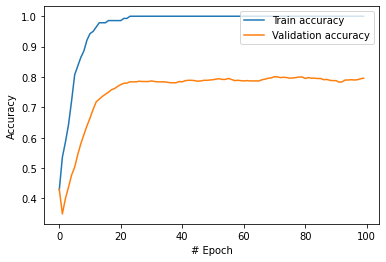

In [29]:
train(data, plot=True)